<!DOCTYPE html>

<html>
  <head>
  </head>

  <body>
    <h1> Study of ethnic residential segregation and health outcomes with clustering analysis in Bradford, UK </h1>
    <p>The Purpose of this file is to understand the hidden pattern in health data of Bradford, UK</p> 
  </body>

The processed data obtained from ethnic and health is used for clustering analysis

## 1. Loading the Raw Data into Python

In [5]:
#Import required packages
import pandas as pd
import numpy as np

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For scaling the data
from sklearn.preprocessing import scale

# To perform PCA
from sklearn.decomposition import PCA

# To perform K-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tqdm import tqdm

#To perform hierarchical clustering
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import warnings
warnings.filterwarnings("ignore")

In [6]:
#Load the required dataset

data = pd.read_csv('Dataset/Processed_Data/processed_clustering_data.csv', index_col=0 )
data.head(2)

,LSOA,Asian_pct,Black_pct,White_pct,Others_pct,Health_Very_Good_pct,Health_Fair_pct,Health_Very_Bad_pct,Disabled_pct,Disability_limited_lot_pct,Disability_limited_little_pct,Disability_No_pct,Disability_phy_mental_yes_pct,Disability_phy_mental_no_pct,unpaid_care_up9to49_pct,unpaid_care_no_pct,unpaid_care_above50_pct
0,E01010568,2.44,0.64,95.12,1.80,83.01,11.98,5.0,17.04,6.05,10.99,82.96,8.61,74.35,13.74,90.82,1.91
1,E01010569,1.20,0.97,95.44,2.39,77.16,14.64,8.2,24.27,11.11,13.16,75.73,6.89,68.83,11.37,89.72,4.21


## 2. Data Preprocessing

### 2.1 checking outliers in the dataset

In [7]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%
data.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,Asian_pct,Black_pct,White_pct,Others_pct,Health_Very_Good_pct,Health_Fair_pct,Health_Very_Bad_pct,Disabled_pct,Disability_limited_lot_pct,Disability_limited_little_pct,Disability_No_pct,Disability_phy_mental_yes_pct,Disability_phy_mental_no_pct,unpaid_care_up9to49_pct,unpaid_care_no_pct,unpaid_care_above50_pct
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000
mean,29.667853,1.905609,63.823397,4.602724,80.613269,13.461346,5.926154,17.326090,8.008622,9.317788,82.673910,5.640833,77.032692,11.423750,90.986410,2.801250
std,29.909094,2.151954,32.173490,2.637621,3.760570,2.189483,1.942547,3.448461,2.179853,2.011761,3.448461,2.374730,4.356441,2.150007,1.312167,0.776901
min,0.200000,0.000000,2.200000,0.490000,67.560000,6.230000,1.700000,9.160000,2.600000,4.490000,71.030000,1.370000,66.690000,3.090000,87.990000,0.350000
25%,3.510000,0.487500,29.125000,2.437500,78.517500,12.175000,4.590000,14.800000,6.667500,7.837500,80.857500,3.550000,73.995000,10.040000,90.080000,2.320000
50%,15.905000,1.140000,77.865000,4.185000,80.675000,13.380000,5.705000,17.060000,7.805000,9.290000,82.940000,5.725000,76.560000,11.430000,91.000000,2.730000
75%,59.372500,2.520000,92.470000,5.972500,82.712500,14.770000,7.232500,19.142500,9.270000,10.685000,85.200000,7.662500,80.192500,13.002500,91.750000,3.210000
90%,76.383000,4.675000,96.038000,8.204000,85.195000,16.039000,8.346000,22.471000,11.068000,12.048000,86.776000,8.655000,83.193000,14.030000,92.430000,3.830000
95%,82.085000,6.466500,97.052000,9.444500,86.863000,16.930000,9.233500,23.918000,11.681500,12.684500,87.566500,9.091500,84.105000,14.619000,93.257000,4.151500
99%,92.291500,10.064600,98.009000,11.379000,89.458300,19.612800,11.810400,26.575100,13.591300,13.357800,88.729100,10.032400,86.093400,15.640000,94.258900,4.927800


Outliers are identified in the dataset,this will be handled in the data pre-processing steps. Same is visualized using box plot.

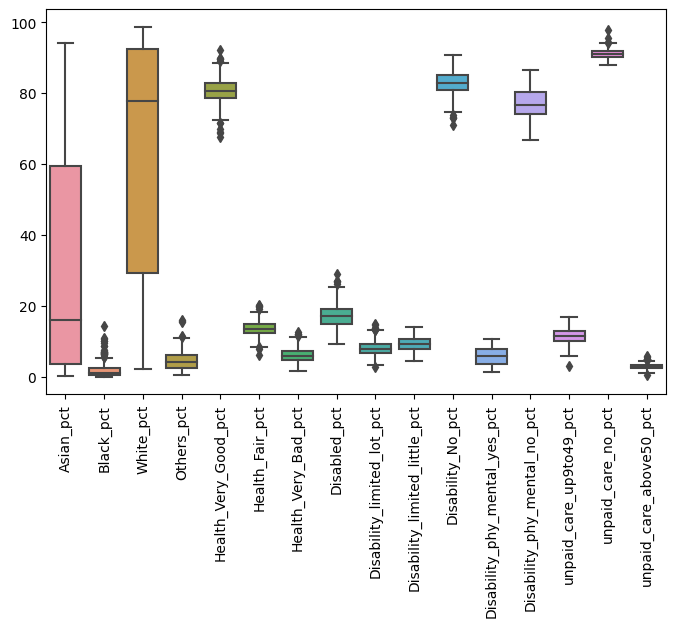

In [8]:
# plotting to check the outliers

fig = plt.figure(figsize = (8,5))
ax = sns.boxplot(data=data)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

In [9]:
##Applying capping to the outliers in the data and to limit the data to a range

def cap_data(df):
    for col in df.columns:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

data=cap_data(data)

capping the  LSOA
capping the  Asian_pct
capping the  Black_pct
capping the  White_pct
capping the  Others_pct
capping the  Health_Very_Good_pct
capping the  Health_Fair_pct
capping the  Health_Very_Bad_pct
capping the  Disabled_pct
capping the  Disability_limited_lot_pct
capping the  Disability_limited_little_pct
capping the  Disability_No_pct
capping the  Disability_phy_mental_yes_pct
capping the  Disability_phy_mental_no_pct
capping the  unpaid_care_up9to49_pct
capping the  unpaid_care_no_pct
capping the  unpaid_care_above50_pct


### 2.2 Checking the datatypes of each variable

In [10]:
# Checking the datatypes of each variable

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 0 to 311
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   LSOA                           312 non-null    object 
 1   Asian_pct                      312 non-null    float64
 2   Black_pct                      312 non-null    float64
 3   White_pct                      312 non-null    float64
 4   Others_pct                     312 non-null    float64
 5   Health_Very_Good_pct           312 non-null    float64
 6   Health_Fair_pct                312 non-null    float64
 7   Health_Very_Bad_pct            312 non-null    float64
 8   Disabled_pct                   312 non-null    float64
 9   Disability_limited_lot_pct     312 non-null    float64
 10  Disability_limited_little_pct  312 non-null    float64
 11  Disability_No_pct              312 non-null    float64
 12  Disability_phy_mental_yes_pct  312 non-null    flo

### 2.3 Checking null and NA values

In [11]:
# Checking of null or NaN values

data.isnull().sum()

LSOA                             0
Asian_pct                        0
Black_pct                        0
White_pct                        0
Others_pct                       0
Health_Very_Good_pct             0
Health_Fair_pct                  0
Health_Very_Bad_pct              0
Disabled_pct                     0
Disability_limited_lot_pct       0
Disability_limited_little_pct    0
Disability_No_pct                0
Disability_phy_mental_yes_pct    0
Disability_phy_mental_no_pct     0
unpaid_care_up9to49_pct          0
unpaid_care_no_pct               0
unpaid_care_above50_pct          0
dtype: int64

In [12]:
data.isna().sum()

LSOA                             0
Asian_pct                        0
Black_pct                        0
White_pct                        0
Others_pct                       0
Health_Very_Good_pct             0
Health_Fair_pct                  0
Health_Very_Bad_pct              0
Disabled_pct                     0
Disability_limited_lot_pct       0
Disability_limited_little_pct    0
Disability_No_pct                0
Disability_phy_mental_yes_pct    0
Disability_phy_mental_no_pct     0
unpaid_care_up9to49_pct          0
unpaid_care_no_pct               0
unpaid_care_above50_pct          0
dtype: int64

### 2.4 plotting correlation matrix

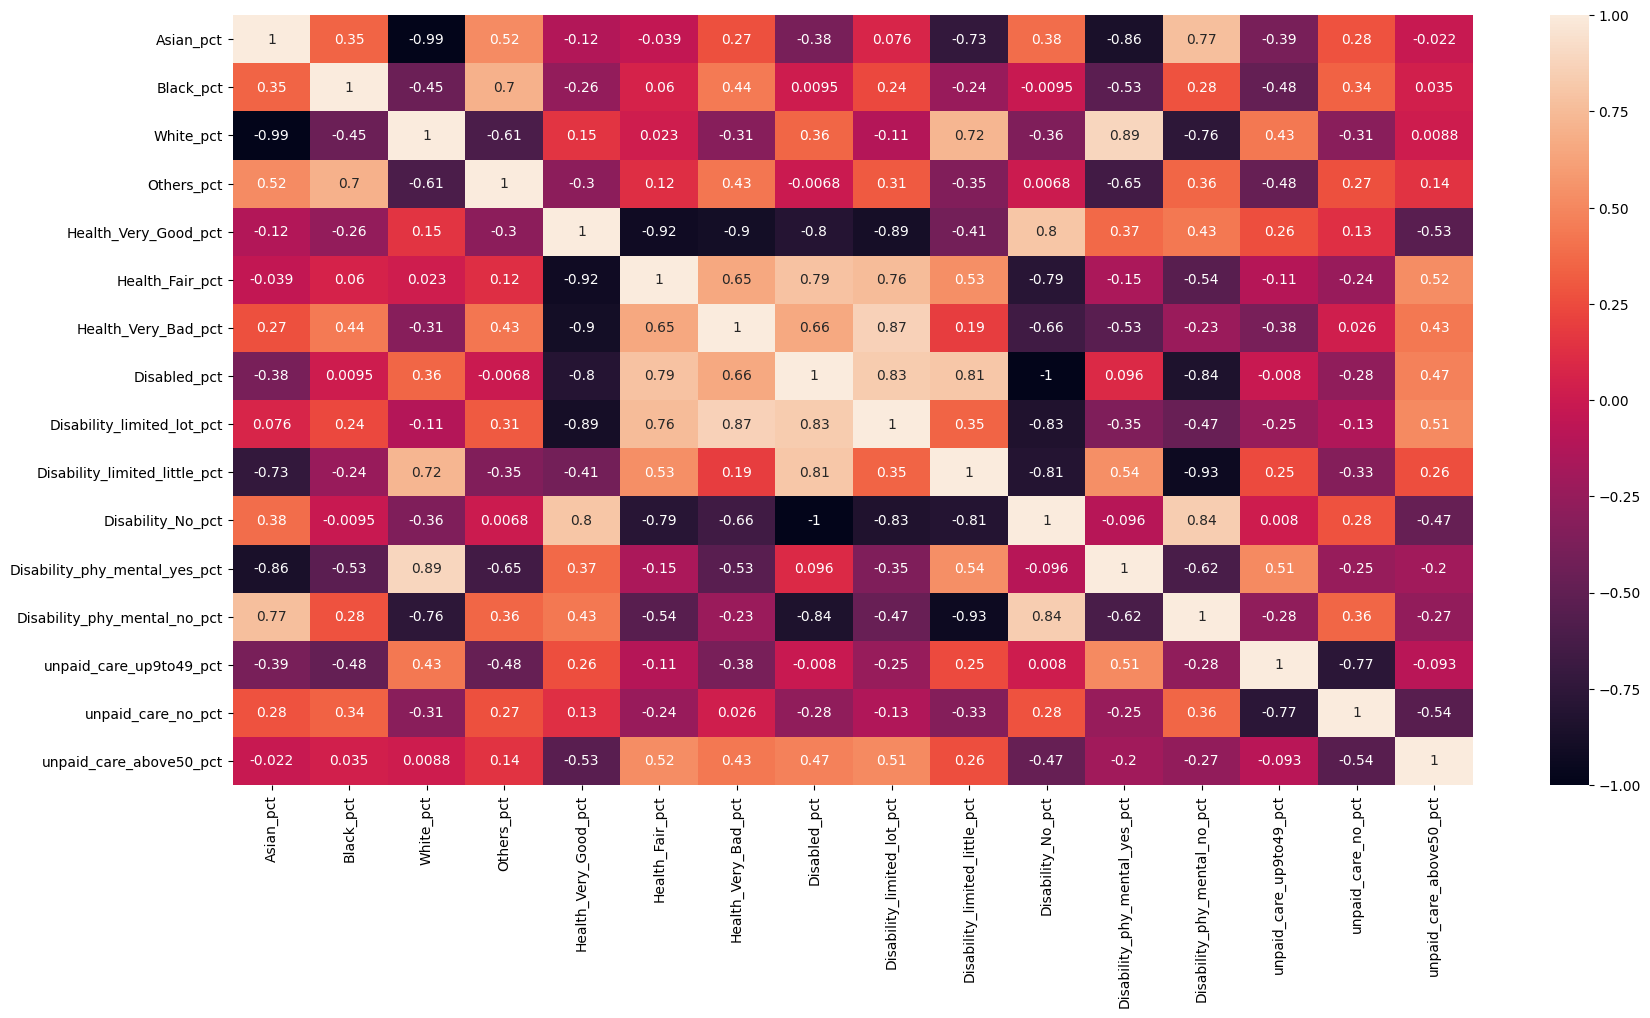

In [13]:
#plotting the correlation matrix

%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(data.corr(),annot = True)
plt.show()

## 3. Performing PCA

The dimensionality reduction technique (PCA) was performed on the raw data to transform the correlated features into uncorrelated features. 

### 3.1 Applying scaling to the data

In [14]:
## First let us see if we can explain the dataset using fewer variables
from sklearn.preprocessing import StandardScaler

data1=data.drop(['LSOA'],1) ## Droping string feature country name.
standard_scaler = StandardScaler()
Country_scaled = standard_scaler.fit_transform(data1)

In [15]:
# Create the dataframe
df = pd.DataFrame(Country_scaled,columns=['Asian_pct', 'Black_pct', 'White_pct',
       'Others_pct', 'Health_Very_Good_pct', 'Health_Fair_pct',
       'Health_Very_Bad_pct', 'Disabled_pct', 'Disability_limited_lot_pct',
       'Disability_limited_little_pct', 'Disability_No_pct',
       'Disability_phy_mental_yes_pct', 'Disability_phy_mental_no_pct',
       'unpaid_care_up9to49_pct', 'unpaid_care_no_pct',
       'unpaid_care_above50_pct'])

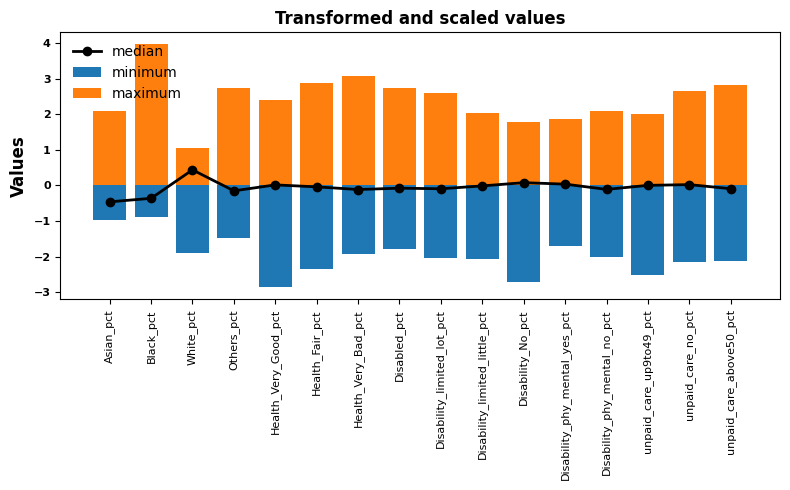

In [16]:
# Graph min, median & max values of each feature after they've been feature engineered
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(df.describe().columns.tolist(), df.describe().iloc[5,:], label="median", color="black", linewidth=2, marker="o")
plt.bar(df.describe().columns.tolist(), df.describe().iloc[3,:], label="minimum")
plt.bar(df.describe().columns.tolist(), df.describe().iloc[-1,:], label="maximum")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8, fontweight="bold")
plt.ylabel("Values", fontsize=12, fontweight="bold")
plt.title("Transformed and scaled values", fontsize=12, fontweight="bold")
ax.title.set_position([.5, 1.025])
plt.legend(loc="best", frameon=False)
plt.grid(False)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 3.2 Perfoming PCA

In [17]:
pca = PCA(svd_solver='randomized', random_state=42)


# fiting PCA on the dataset
pca.fit(Country_scaled)

PCA(random_state=42, svd_solver='randomized')

In [18]:
# List of PCA components.
pca.components_

array([[-1.88754350e-01, -3.41248703e-02,  1.81394447e-01,
        -4.40131644e-02, -3.00813145e-01,  3.14867535e-01,
         2.27578554e-01,  3.80821322e-01,  2.96557571e-01,
         3.29620170e-01, -3.80821322e-01,  8.45822437e-02,
        -3.46816355e-01,  4.25411845e-02, -1.60730374e-01,
         2.12646937e-01],
       [ 3.29804554e-01,  2.87668194e-01, -3.51836118e-01,
         3.31041005e-01, -2.52733270e-01,  1.54550886e-01,
         3.13438107e-01,  5.36067553e-02,  2.39650771e-01,
        -1.64906436e-01, -5.36067553e-02, -3.92411067e-01,
         1.70721719e-01, -2.85171155e-01,  1.44381219e-01,
         1.15848043e-01],
       [-2.24969716e-01,  2.30192467e-01,  1.85845240e-01,
         5.96215382e-02,  3.86574983e-02, -7.88155539e-02,
         2.33579103e-02,  7.97555534e-02, -1.63240682e-02,
         1.52767706e-01, -7.97555534e-02,  1.59281102e-01,
        -1.46238558e-01, -4.48955389e-01,  6.44706440e-01,
        -3.86994993e-01],
       [-2.72905687e-01,  6.42814386e

### 3.3 checking variance ratios of each features

In [19]:
pca.explained_variance_ratio_

array([4.09590691e-01, 3.36635043e-01, 9.84205870e-02, 5.09879874e-02,
       4.03549937e-02, 2.02828632e-02, 1.81806093e-02, 1.12881109e-02,
       7.13073137e-03, 6.36889325e-03, 5.81349843e-04, 9.46368373e-05,
       4.62088022e-05, 3.17256824e-05, 5.56926067e-06, 2.02272027e-32])

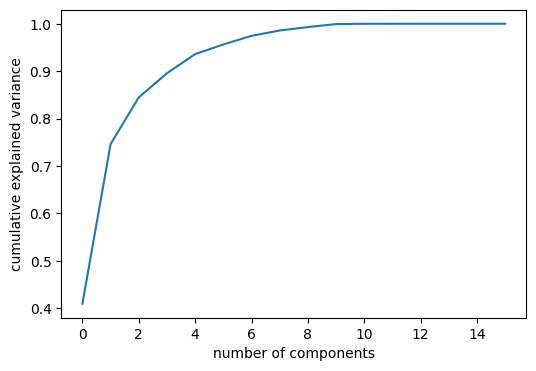

In [20]:
# Plotting the scree plot
%matplotlib inline
fig = plt.figure(figsize = (6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [21]:
# Convert dataframe into numpy array (allows for faster computation)
X = df.values

df_pca = pd.DataFrame({
    "principal_component": range(1, X.shape[1]+1),
    "explained_variance": pca.explained_variance_ratio_,
    "cumsum_explained_variance": pca.explained_variance_ratio_.cumsum(),
})
df_pca.loc[-1] = 0
df_pca.sort_values(by="principal_component", inplace=True)

print(df_pca.shape)
df_pca.head()

(17, 3)


,principal_component,explained_variance,cumsum_explained_variance
-1,0,0.000000,0.000000
0,1,0.409591,0.409591
1,2,0.336635,0.746226
2,3,0.098421,0.844646
3,4,0.050988,0.895634


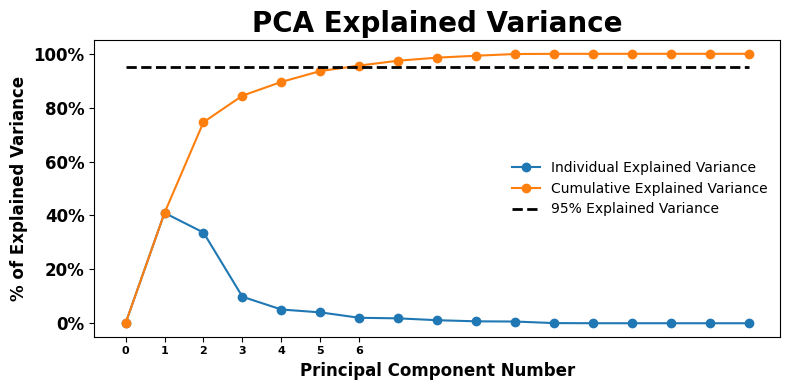

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(df_pca["principal_component"], df_pca["explained_variance"], marker="o", label="Individual Explained Variance")
plt.plot(df_pca["principal_component"], df_pca["cumsum_explained_variance"], marker="o", label="Cumulative Explained Variance")
plt.plot(df_pca["principal_component"], [0.95] * len(df_pca), color="black", linewidth=2, linestyle="--", label="95% Explained Variance")
ax.set_xticklabels(["{:,.0f}".format(x) for x in ax.get_xticks()])
ax.set_yticklabels(["{:,.0%}".format(x) for x in ax.get_yticks()])
plt.title("PCA Explained Variance", fontsize=20, fontweight="bold")
ax.title.set_position([.5, 1.025])
plt.xticks(range(0,7), range(0,7), fontsize=8, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")
plt.xlabel("Principal Component Number", fontsize=12, fontweight="bold")
plt.ylabel("% of Explained Variance", fontsize=12, fontweight="bold")
plt.grid(False)
plt.legend(loc="best", frameon=False)
plt.tight_layout()
plt.show()

In [23]:
n_components_pca = int(df_pca["cumsum_explained_variance"].gt(0.95).idxmax())
print("# of Features Until 95% Variance is Reached:", n_components_pca)

# of Features Until 95% Variance is Reached: 5


<div class="alert alert-block alert-info">
<b>Insight:</b> 
From above scree plot, Around 98% of the information is being explained by 5 components
</div>

In [24]:
colnames = list(data1.columns)
pcs_df = pd.DataFrame({ 'Feature':colnames,'PC1':pca.components_[0],'PC2':pca.components_[1],'PC3':pca.components_[2],
                      'PC4':pca.components_[3],'PC5':pca.components_[4]
                      })
pcs_df

,Feature,PC1,PC2,PC3,PC4,PC5
0,Asian_pct,-0.188754,0.329805,-0.224970,-0.272906,-0.117449
1,Black_pct,-0.034125,0.287668,0.230192,0.642814,-0.185011
2,White_pct,0.181394,-0.351836,0.185845,0.168617,0.128936
3,Others_pct,-0.044013,0.331041,0.059622,0.507707,-0.091279
4,Health_Very_Good_pct,-0.300813,-0.252733,0.038657,0.148647,0.082812
5,Health_Fair_pct,0.314868,0.154551,-0.078816,-0.209916,-0.017324
6,Health_Very_Bad_pct,0.227579,0.313438,0.023358,-0.048837,-0.141505
7,Disabled_pct,0.380821,0.053607,0.079756,-0.025757,-0.077908
8,Disability_limited_lot_pct,0.296558,0.239651,-0.016324,-0.090488,-0.093794
9,Disability_limited_little_pct,0.329620,-0.164906,0.152768,0.051441,-0.030365


In [25]:
#Plotting the principal components and try to make sense of them.

#Plotting original features on the first 2 principal components as axes

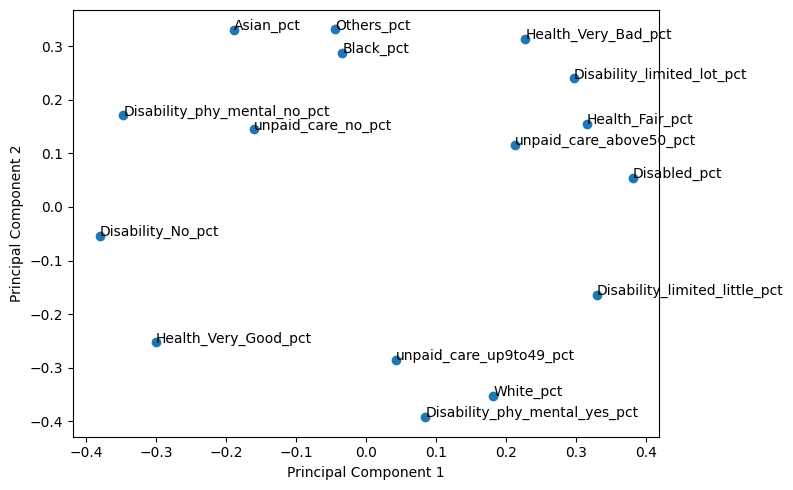

In [26]:
%matplotlib inline
fig = plt.figure(figsize = (8,5))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [27]:
#From the above plot, the first component is in the dirction where the very bad health, disability is lot are heavy and second component is in the direction where no diablity with physical and mental is more.

### 3.4 Performing Incremental PCA

In [28]:
#Performing dimenstionality reduction using the 8 Principal Components
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=5)

In [29]:
df_pca = pca_final.fit_transform(Country_scaled)
df_pca.shape

(312, 5)

In [30]:
# Inertia Scree Plot

In [31]:
X = df_pca

# Define range of clusters to check

inertia_scores = []
silhouette_scores = []
no_of_clusters = range(2, 4)

In [32]:
# Calculate intertia & silhouette average for each cluster

for cluster in tqdm(no_of_clusters):
    kmeans = KMeans(n_clusters=cluster, init="k-means++", random_state=42)
    kmeans = kmeans.fit(X)
    
    inertia = kmeans.inertia_
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    
    inertia_scores.append(round(inertia))


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 11.28it/s]


### 3.5 Calculate Inertia

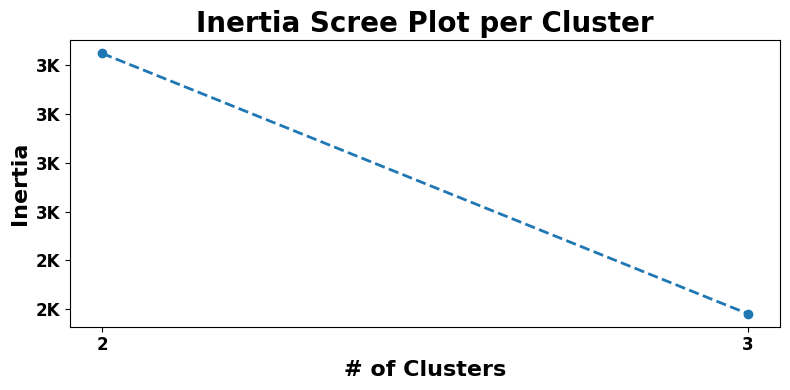

In [33]:
# Interia scree plot

fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(range(1, len(no_of_clusters)+1), inertia_scores, marker="o", linewidth=2, linestyle="--")
plt.xticks(range(1, len(no_of_clusters)+1), no_of_clusters, fontsize=12, fontweight="bold")
ax.set_yticklabels(["{:,.0f}".format(x/1000) + "K" for x in ax.get_yticks()])
plt.yticks(fontsize=12, fontweight="bold")
plt.xlabel("# of Clusters", fontsize=16, fontweight="bold")
plt.ylabel("Inertia", fontsize=16, fontweight="bold")
plt.title("Inertia Scree Plot per Cluster", fontsize=20, fontweight="bold")
ax.title.set_position([.5, 1.025])
plt.grid(False)
plt.tight_layout()
plt.show()

In [34]:
slopes = [0]
slopes_pct_change = []
inertia_df = pd.DataFrame()
inertia_df["inertia"] = inertia_scores
inertia_df["n_clusters"] = inertia_df.index + 2

In [35]:
def derivative_calc(df, x_field, y_field):
    x_values = df[x_field].values
    y_values = df[y_field].values
    for i in range(1, len(x_values)):
        (x1, y1) = (x_values[i-1], y_values[i-1])
        (x2, y2) = (x_values[i], y_values[i])
        slope = round((y2 - y1) / (x2 - x1), 4)
        slopes.append(slope)
        slopes_pct_change.append((abs(slopes[i-1]) - abs(slopes[i])) / abs(slopes[i-1]))
    df["slopes"] = slopes
    df["slopes_pct_change"] = slopes_pct_change + [0]

In [36]:
# Define optimal number of clusters

derivative_calc(inertia_df, "n_clusters", "inertia")
n_clusters_kmeans = int(inertia_df.loc[inertia_df["slopes_pct_change"].idxmax()]["n_clusters"])
print("# of Clusters for KMeans Algorithm:", n_clusters_kmeans)

# of Clusters for KMeans Algorithm: 3


In [37]:
inertia_df[["n_clusters", "inertia", "slopes", "slopes_pct_change"]].head()

,n_clusters,inertia,slopes,slopes_pct_change
0,2,3249,0.0,-inf
1,3,2181,-1068.0,0.0


In [38]:
# Creating a transpose so that the each column is properly arranged

In [39]:
pc = np.transpose(df_pca)

In [40]:
# Creating correlation matrix for the principal components¶

In [41]:
corrmat = np.corrcoef(pc)

In [42]:
# Plotting the correlation matrix of the principal components

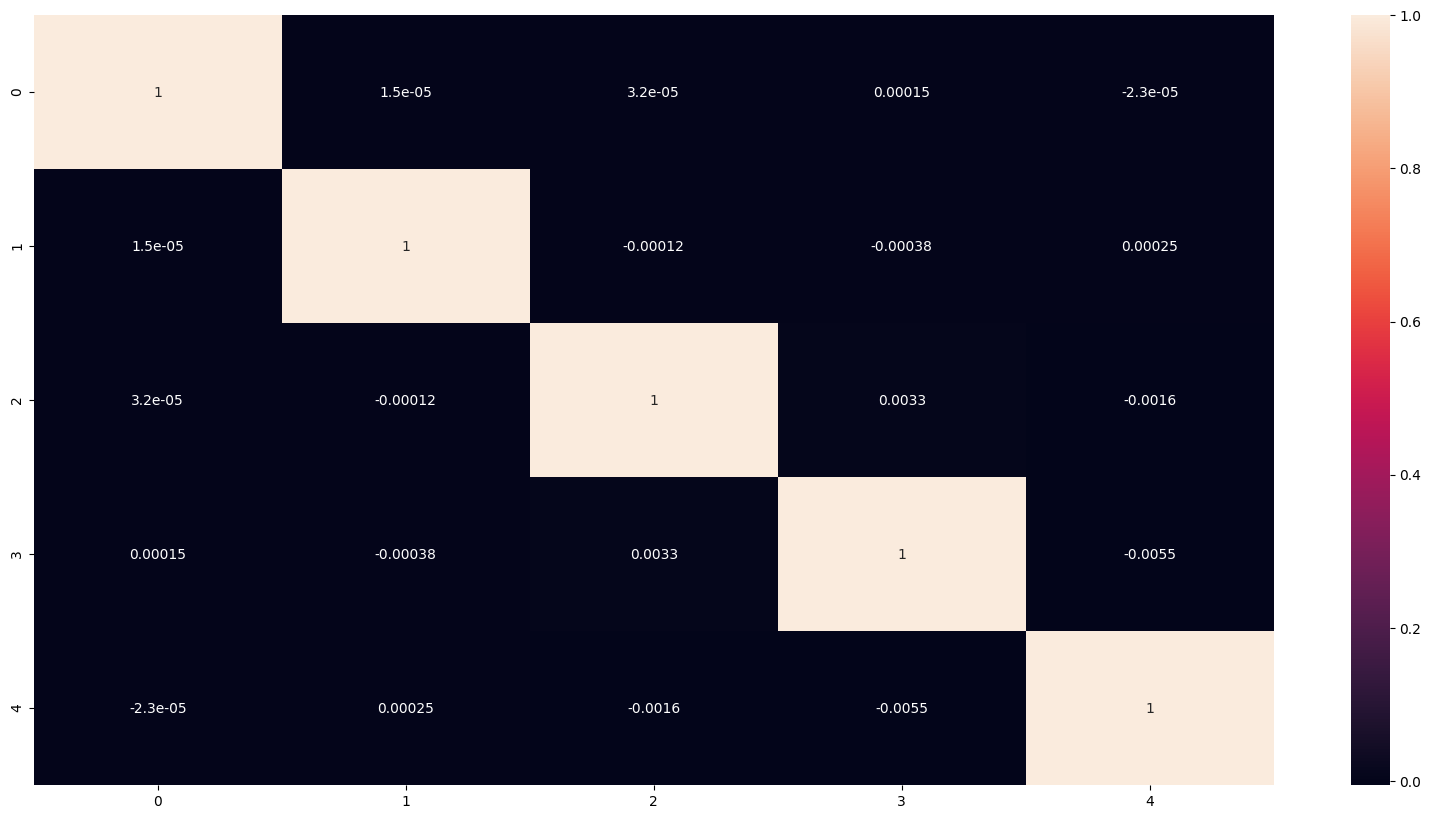

In [43]:
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(corrmat,annot = True)
plt.show()

<div class="alert alert-block alert-info">
<b>Insight:</b> From above heat map, all the components are not correlated to each other.
These uncorrelated features are called as Principal Components.   
</div>

In [44]:
# Creating the dataframe of all 8 principal components

In [45]:
pcs_df2 = pd.DataFrame({'PC1':pc[0],'PC2':pc[1],'PC3':pc[2],'PC4':pc[3],'PC5':pc[4]})

In [46]:
# Checking outliers of all the principal complnents

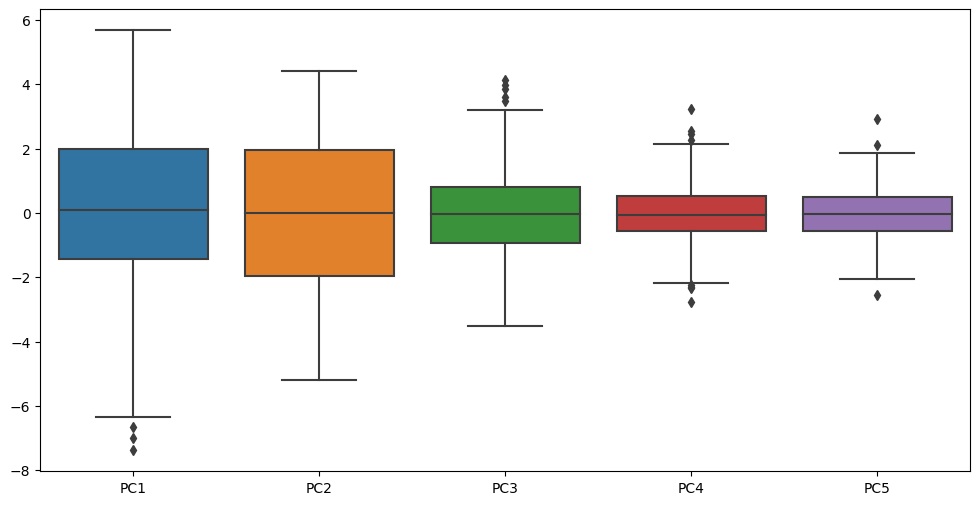

In [47]:
fig = plt.figure(figsize = (12,6))
sns.boxplot(data=pcs_df2)
plt.show()

In [48]:
# From above boxplots, there is Outlier in the PC1, So outlier treatment can be done

In [49]:
pcs_df2.shape

(312, 5)

In [50]:
pcs_df2.head()

,PC1,PC2,PC3,PC4,PC5
0,0.024420,3.044545,0.548275,-0.163418,-0.851572
1,-5.023779,0.588493,-0.215469,0.039661,0.910724
2,-0.140401,3.345080,-0.147517,-0.011391,-0.659668
3,-0.809281,1.472416,1.751808,0.170978,-0.494251
4,0.634435,3.447666,0.866698,-0.322063,-0.507710


<div class="alert alert-block alert-info">
<b>Result:</b> PCA is to reduce the number of variables and retaining only the important features called as Principal components. There are 5 principal components formed which retains 95% of variance.
</div>

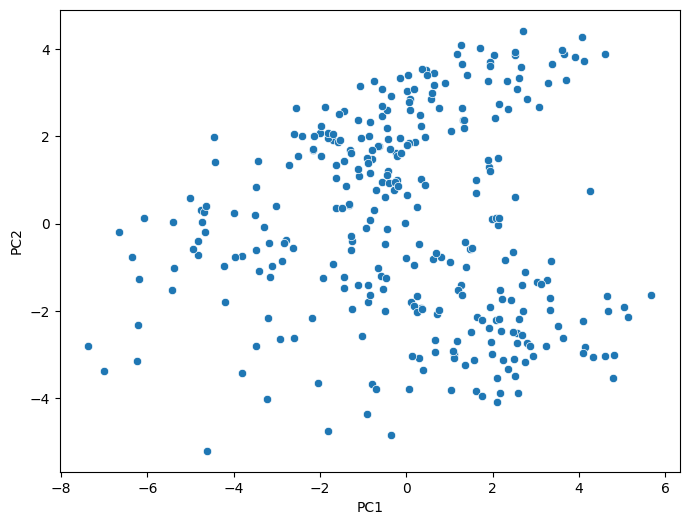

In [51]:
#Visualising the points on the PCs.

fig = plt.figure(figsize = (8,6))
sns.scatterplot(x='PC1',y='PC2',data=pcs_df2)
plt.show()

In [52]:
# There are some grouping as before and after 0 value of PC2

## 4. Performing clustering

In [53]:
# Clustering Process

# Let's go ahead and begin with the clustering process i.e first  the Hopkins statistic is calculated

In [54]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [55]:
pcs_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PC1     312 non-null    float64
 1   PC2     312 non-null    float64
 2   PC3     312 non-null    float64
 3   PC4     312 non-null    float64
 4   PC5     312 non-null    float64
dtypes: float64(5)
memory usage: 12.3 KB


### 4.1 Checking the Hopkins measure

In [56]:
# The Hopkins statistical analysis is performed to measure the cluster tendency of a data set.
hopkins(pcs_df2)

0.6935269612575434

<div class="alert alert-block alert-info">
<b>Insight:</b> Hopkins score is > 0.5 which means the given dataset has a good tendency to form clusters
</div>

### 4.2 Silhouette score analysis

Silhouette Analysis was performed to identify the K value to from clusters

In [57]:
dat3_1 = pcs_df2

In [58]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(dat3_1)
    sse_.append([k, silhouette_score(dat3_1, kmeans.labels_)])

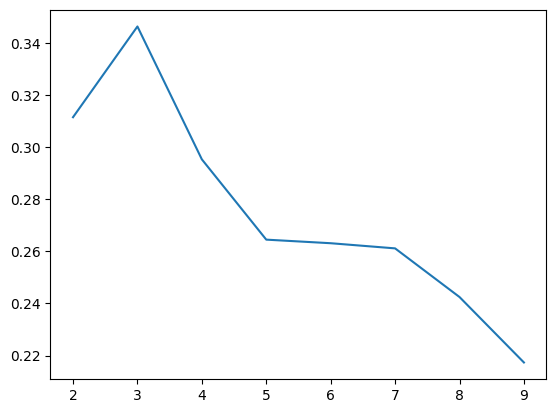

In [59]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.show()

<div class="alert alert-block alert-info">
<b>Insight:</b> From the above analysis, 3 seems to be a good number of clusters for K means algorithm.
</div>


### 4.3 Elbow curve¶

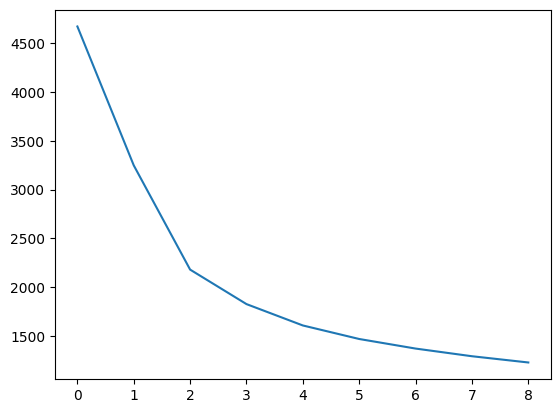

In [60]:
ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(dat3_1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)
plt.show()

<div class="alert alert-block alert-info">
<b>Insight:</b> 
A distinct bend at around 3 clusters. Hence, checking with Silhouette Analysis also .
</div>

### 4.5 Silhouette Analysis with scores

In [61]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(dat3_1)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(dat3_1, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.31142417434822195
For n_clusters=3, the silhouette score is 0.3462390137007731
For n_clusters=4, the silhouette score is 0.2913351519863802
For n_clusters=5, the silhouette score is 0.26445426793753496
For n_clusters=6, the silhouette score is 0.2602947570897069
For n_clusters=7, the silhouette score is 0.265015957987368
For n_clusters=8, the silhouette score is 0.251822366755009


<div class="alert alert-block alert-info">
<b>Insight:</b> 
n_clusters=3 again proves to have high silhouette score showing 3 is the cluster to be chosen
</div>

### 4.6 Performing k-means clustering using K=3

In [62]:
model_clus2 = KMeans(n_clusters = 3, max_iter=150,random_state = 50)
model_clus2.fit(dat3_1)

KMeans(max_iter=150, n_clusters=3, random_state=50)

In [63]:
dat4=pcs_df2
dat4.index = pd.RangeIndex(len(dat4.index))
dat_km = pd.concat([dat4, pd.Series(model_clus2.labels_)], axis=1)
dat_km.columns = ['PC1', 'PC2','PC3','PC4','PC5','ClusterID']
dat_km

,PC1,PC2,PC3,PC4,PC5,ClusterID
0,0.024420,3.044545,0.548275,-0.163418,-0.851572,1
1,-5.023779,0.588493,-0.215469,0.039661,0.910724,0
2,-0.140401,3.345080,-0.147517,-0.011391,-0.659668,1
3,-0.809281,1.472416,1.751808,0.170978,-0.494251,1
4,0.634435,3.447666,0.866698,-0.322063,-0.507710,1
...,...,...,...,...,...,...
307,1.742969,-2.219155,-2.144357,-0.192180,-0.732842,2
308,3.119097,-1.395433,-1.692351,-0.342237,1.806233,2
309,2.602921,-2.183933,-0.271010,-0.229134,-1.262479,2
310,4.780142,-3.547576,0.230061,1.153575,-0.017087,2


In [64]:
#Assinging the result to validation_df for validating the clusters in the end

validation_df = dat_km.copy()

In [65]:
dat_km['ClusterID'].value_counts()

1    137
2    106
0     69
Name: ClusterID, dtype: int64

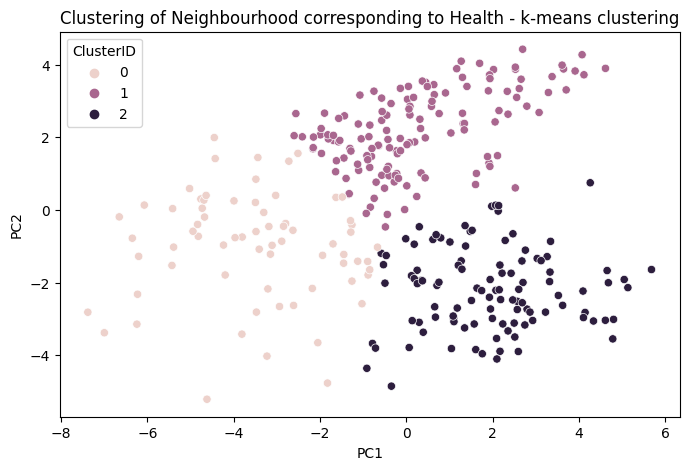

In [66]:
fig = plt.figure(figsize = (8,5))
sns.scatterplot(x='PC1',y='PC2',hue='ClusterID',legend='full',data=dat_km)

plt.title('Clustering of Neighbourhood corresponding to Health - k-means clustering')
plt.show()

<div class="alert alert-block alert-info">
<b>Insight:</b> 
From above plots, we can clearly see the 3 clusters .
</div>

In [67]:
# Now we are merging clusters with the original dataset.
data = data.reset_index()

In [68]:
dat5=pd.merge(data,dat_km, left_index=True,right_index=True)
dat5.head(2)

,index,LSOA,Asian_pct,Black_pct,White_pct,Others_pct,Health_Very_Good_pct,Health_Fair_pct,Health_Very_Bad_pct,Disabled_pct,...,Disability_phy_mental_no_pct,unpaid_care_up9to49_pct,unpaid_care_no_pct,unpaid_care_above50_pct,PC1,PC2,PC3,PC4,PC5,ClusterID
0,0,E01010568,2.44,0.64,95.12,1.80,83.01,11.98,5.0,17.04,...,74.35,13.74,90.82,1.91,0.024420,3.044545,0.548275,-0.163418,-0.851572,1
1,1,E01010569,1.20,0.97,95.44,2.39,77.16,14.64,8.2,24.27,...,68.83,11.37,89.72,4.21,-5.023779,0.588493,-0.215469,0.039661,0.910724,0


In [69]:
# Dropping all the principal components from merged dataframe.
dat6=dat5.drop(['PC1','PC2','PC3','PC4','PC5'],axis=1)
dat6.head(2)

,index,LSOA,Asian_pct,Black_pct,White_pct,Others_pct,Health_Very_Good_pct,Health_Fair_pct,Health_Very_Bad_pct,Disabled_pct,Disability_limited_lot_pct,Disability_limited_little_pct,Disability_No_pct,Disability_phy_mental_yes_pct,Disability_phy_mental_no_pct,unpaid_care_up9to49_pct,unpaid_care_no_pct,unpaid_care_above50_pct,ClusterID
0,0,E01010568,2.44,0.64,95.12,1.80,83.01,11.98,5.0,17.04,6.05,10.99,82.96,8.61,74.35,13.74,90.82,1.91,1
1,1,E01010569,1.20,0.97,95.44,2.39,77.16,14.64,8.2,24.27,11.11,13.16,75.73,6.89,68.83,11.37,89.72,4.21,0


## 5. Analysis of the clusters

In [70]:
# calculating the mean of all the variables of each clusters.

Cluster_Asian_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).Asian_pct.mean())
Cluster_Black_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).Black_pct.mean())
Cluster_White_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).White_pct.mean())
Cluster_Others_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).Others_pct.mean())
Cluster_Health_Very_Good_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).Health_Very_Good_pct.mean())
Cluster_Health_Fair_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).Health_Fair_pct.mean())
Cluster_Health_Very_Bad_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).Health_Very_Bad_pct.mean())
Cluster_Disabled_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).Disabled_pct.mean())
Cluster_Disability_limited_lot_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).Disability_limited_lot_pct.mean())
Cluster_Disability_limited_little_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).Disability_limited_little_pct.mean())
Cluster_Disability_No_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).Disability_No_pct.mean())
Cluster_Disability_phy_mental_yes_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).Disability_phy_mental_yes_pct.mean())
Cluster_Disability_phy_mental_no_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).Disability_phy_mental_no_pct.mean())
Cluster_unpaid_care_up9to49_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).unpaid_care_up9to49_pct.mean())
Cluster_unpaid_care_no_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).unpaid_care_no_pct.mean())
Cluster_unpaid_care_above50_pct=pd.DataFrame(dat6.groupby(["ClusterID"]).unpaid_care_above50_pct.mean())

In [71]:
# Concatenating all the grouped by data to create a new dataframe to find required mean.

df = pd.concat([Cluster_Asian_pct,Cluster_Black_pct,Cluster_White_pct,Cluster_Others_pct,
                Cluster_Health_Very_Good_pct, Cluster_Health_Fair_pct, Cluster_Health_Very_Bad_pct, 
                Cluster_Disabled_pct, Cluster_Disability_limited_lot_pct, Cluster_Disability_limited_little_pct, Cluster_Disability_No_pct, 
                Cluster_Disability_phy_mental_yes_pct, Cluster_Disability_phy_mental_no_pct,
                Cluster_unpaid_care_up9to49_pct, Cluster_unpaid_care_no_pct, Cluster_unpaid_care_above50_pct], axis=1)

In [72]:
# creating datframe 

df.columns = ['Asian_pct', 'Black_pct', 'White_pct',
       'Others_pct', 'Health_Very_Good_pct', 'Health_Fair_pct',
       'Health_Very_Bad_pct', 'Disabled_pct', 'Disability_limited_lot_pct',
       'Disability_limited_little_pct', 'Disability_No_pct',
       'Disability_phy_mental_yes_pct', 'Disability_phy_mental_no_pct',
       'unpaid_care_up9to49_pct', 'unpaid_care_no_pct',
       'unpaid_care_above50_pct']
df

,Asian_pct,Black_pct,White_pct,Others_pct,Health_Very_Good_pct,Health_Fair_pct,Health_Very_Bad_pct,Disabled_pct,Disability_limited_lot_pct,Disability_limited_little_pct,Disability_No_pct,Disability_phy_mental_yes_pct,Disability_phy_mental_no_pct,unpaid_care_up9to49_pct,unpaid_care_no_pct,unpaid_care_above50_pct
ClusterID,,,,,,,,,,,,,,,,
0,16.214009,2.380133,76.222174,5.102014,76.084684,15.867119,8.083646,22.075368,10.863264,11.211612,77.924632,5.375072,72.550325,10.899565,90.523039,3.484510
1,8.443794,0.707883,87.945956,2.900274,82.896228,12.609991,4.500607,16.559582,6.652797,9.901898,83.440418,7.709340,75.740438,12.660146,90.701168,2.540137
2,65.819113,3.093955,24.575974,6.361292,80.629057,13.009906,6.361792,15.216612,7.896226,7.328121,84.783388,3.135796,81.644940,10.173336,91.614014,2.688928


In [73]:
df.to_excel('Dataset/Processed_Data/check.xlsx')

In [74]:
#Analysing the clusters by comparing how the [Health_Very_Good_pct, Disability_No_pct and unpaid_care_above50_pct] vary for each cluster

#From above dataframe of means, we got the mean data of area with healthy neighourhood. So, creating a dataframe on the basis of same.

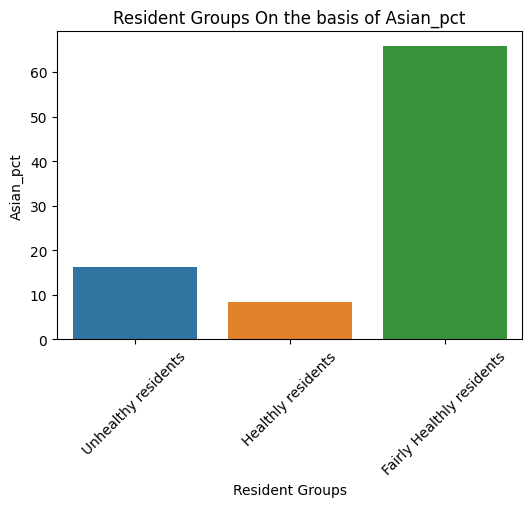

In [75]:
fig = plt.figure(figsize = (6,4))
df.rename(index={0: 'Unhealthy residents'},inplace=True)
df.rename(index={1: 'Healthly residents'},inplace=True)
df.rename(index={2: 'Fairly Healthly residents'},inplace=True)
s=sns.barplot(x=df.index,y='Asian_pct',data=df)
plt.xlabel('Resident Groups', fontsize=10)
plt.xticks(rotation = 45)
plt.title('Resident Groups On the basis of Asian_pct')
plt.title
plt.show()

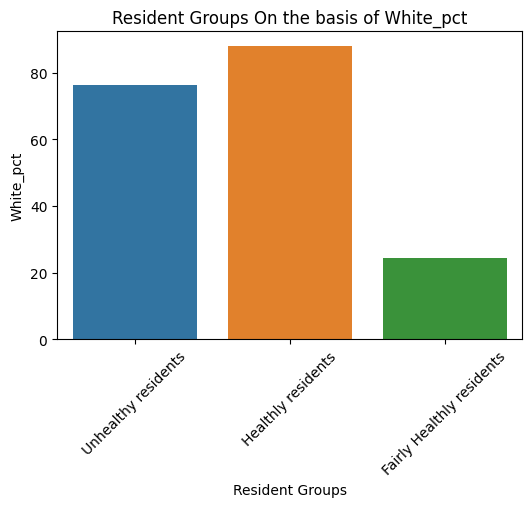

In [76]:
fig = plt.figure(figsize = (6,4))
sns.barplot(x=df.index,y='White_pct',data=df)
plt.xlabel('Resident Groups', fontsize=10)
plt.title('Resident Groups On the basis of White_pct')
plt.xticks(rotation = 45)
plt.show()

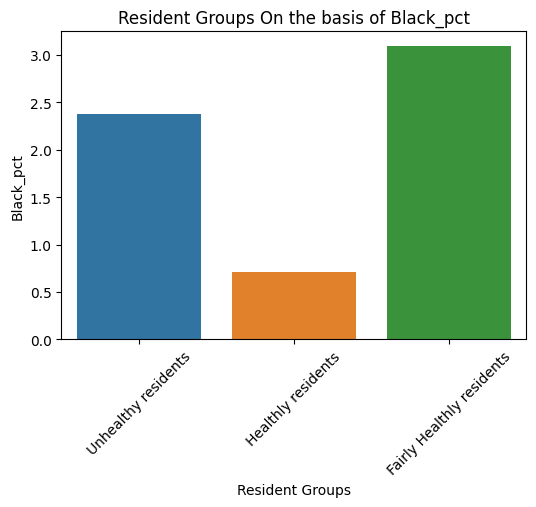

In [77]:
fig = plt.figure(figsize = (6,4))
sns.barplot(x=df.index,y='Black_pct',data=df)
plt.xlabel('Resident Groups', fontsize=10)
plt.title('Resident Groups On the basis of Black_pct')
plt.xticks(rotation = 45)
plt.show()

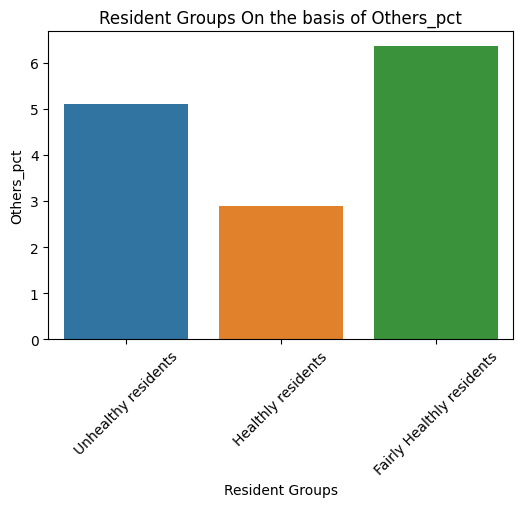

In [78]:
fig = plt.figure(figsize = (6,4))
sns.barplot(x=df.index,y='Others_pct',data=df)
plt.xlabel('Resident Groups', fontsize=10)
plt.title('Resident Groups On the basis of Others_pct')
plt.xticks(rotation = 45)
plt.show()

<div class="alert alert-block alert-info">
<b>Insight:</b> 
The bar plot shows Asians are finding more in fairly health residence. White community is found highly in healthy as well as unhealthy residents. Black is with less population when compared to other ethnic group, nevertheless they are higher in fairly health neighbourhoods. Similar trend is seen in another ethnic group. Albeit they are less in population, most of the population fall under the category of fair and unhealthy residential area.
</div> 

In [79]:
#Let's use the concept of binning
fin=data[data['Health_Very_Good_pct'] >= 82.896228]
fin=fin[fin['Disabled_pct'] <= 15.216612]
fin=fin[fin['unpaid_care_no_pct'] <= 90.523039]

In [80]:
# merging to get cluster ID

fin_k=pd.merge(fin,dat_km,left_index=True,right_index=True)

In [81]:
fin_k=fin_k.drop(['PC1','PC2','PC3','PC4','PC5'],axis=1)

In [82]:
fin_k.shape

(16, 19)

In [83]:
fin_k_Health_Very_Good_pct=fin_k.nsmallest(8,'Health_Very_Good_pct')
fin_k_Health_Very_Good_pct

,index,LSOA,Asian_pct,Black_pct,White_pct,Others_pct,Health_Very_Good_pct,Health_Fair_pct,Health_Very_Bad_pct,Disabled_pct,Disability_limited_lot_pct,Disability_limited_little_pct,Disability_No_pct,Disability_phy_mental_yes_pct,Disability_phy_mental_no_pct,unpaid_care_up9to49_pct,unpaid_care_no_pct,unpaid_care_above50_pct,ClusterID
245,245,E01010818,27.0300,1.79,64.82,6.3700,83.44,12.18,4.38,14.86,7.02,7.84,85.14,5.6200,79.52,14.90,89.67,2.39,1
136,136,E01010707,17.3200,0.27,76.60,5.8100,84.27,12.07,3.66,14.69,5.46,9.23,85.31,7.5900,77.72,13.89,89.66,2.80,1
78,78,E01010646,0.8200,0.30,97.92,0.9700,84.72,12.76,2.52,14.02,4.75,9.27,85.98,10.0324,75.22,14.04,90.10,2.23,1
286,286,E01010862,0.4366,0.18,97.74,1.8300,85.13,11.20,3.67,15.17,5.26,9.91,84.83,8.2000,76.64,12.76,90.13,3.21,1
5,5,E01010573,2.0200,0.33,96.77,0.8744,85.15,10.97,3.88,14.15,5.85,8.31,85.85,8.0300,77.81,14.40,89.44,2.87,1
287,287,E01010863,1.4900,0.35,96.61,1.5600,85.49,10.62,3.89,14.72,5.10,9.62,85.28,8.8500,76.43,15.27,89.40,2.59,1
199,199,E01010771,1.5500,0.33,95.93,2.2000,86.02,10.96,3.03,14.54,4.82,9.72,85.46,10.0324,75.41,12.41,90.50,3.00,1
224,224,E01010797,8.1400,1.20,88.17,2.4800,86.07,10.96,2.97,13.71,5.30,8.41,86.29,7.8400,78.45,14.81,90.28,1.80,1


In [84]:
# Above list shows all the top very good health residents.

In [85]:
fin_k_Disabled_pct=fin_k.nsmallest(8,'Disabled_pct')
fin_k_Disabled_pct

,index,LSOA,Asian_pct,Black_pct,White_pct,Others_pct,Health_Very_Good_pct,Health_Fair_pct,Health_Very_Bad_pct,Disabled_pct,Disability_limited_lot_pct,Disability_limited_little_pct,Disability_No_pct,Disability_phy_mental_yes_pct,Disability_phy_mental_no_pct,unpaid_care_up9to49_pct,unpaid_care_no_pct,unpaid_care_above50_pct,ClusterID
110,110,E01010681,10.26,0.80,84.48,4.46,87.75,9.79,2.46,11.44,3.6333,8.05,88.56,6.6500,81.90,15.64,89.67,2.1200,1
192,192,E01010764,2.65,0.06,95.50,1.79,86.95,10.46,2.58,12.79,4.3200,8.46,87.21,7.1600,80.05,14.18,90.04,2.6200,1
18,18,E01010586,1.63,0.13,96.18,2.07,86.45,10.49,3.06,13.49,5.0600,8.43,86.51,9.4900,77.01,13.51,90.13,2.8600,1
194,194,E01010766,1.56,0.08,96.63,1.73,87.74,9.38,2.88,13.57,4.6900,8.88,86.43,8.7200,77.71,15.64,90.27,1.1988,1
224,224,E01010797,8.14,1.20,88.17,2.48,86.07,10.96,2.97,13.71,5.3000,8.41,86.29,7.8400,78.45,14.81,90.28,1.8000,1
9,9,E01010577,1.42,0.64,95.62,2.32,87.18,10.05,2.77,13.86,4.3200,9.54,86.14,6.8300,79.30,15.64,88.58,2.6900,1
22,22,E01010590,3.85,0.36,93.84,1.95,86.18,10.50,3.32,13.90,5.1800,8.72,86.10,9.1300,76.98,13.76,90.39,2.3200,1
78,78,E01010646,0.82,0.30,97.92,0.97,84.72,12.76,2.52,14.02,4.7500,9.27,85.98,10.0324,75.22,14.04,90.10,2.2300,1


In [86]:
# Above list shows all the top low Disabled_pct residents.

In [87]:
fin_k_unpaid_care_above50_pct=fin_k.nlargest(8,'unpaid_care_no_pct')
fin_k_unpaid_care_above50_pct

,index,LSOA,Asian_pct,Black_pct,White_pct,Others_pct,Health_Very_Good_pct,Health_Fair_pct,Health_Very_Bad_pct,Disabled_pct,Disability_limited_lot_pct,Disability_limited_little_pct,Disability_No_pct,Disability_phy_mental_yes_pct,Disability_phy_mental_no_pct,unpaid_care_up9to49_pct,unpaid_care_no_pct,unpaid_care_above50_pct,ClusterID
199,199,E01010771,1.5500,0.33,95.93,2.20,86.02,10.96,3.03,14.54,4.82,9.72,85.46,10.0324,75.41,12.41,90.50,3.0000,1
22,22,E01010590,3.8500,0.36,93.84,1.95,86.18,10.50,3.32,13.90,5.18,8.72,86.10,9.1300,76.98,13.76,90.39,2.3200,1
224,224,E01010797,8.1400,1.20,88.17,2.48,86.07,10.96,2.97,13.71,5.30,8.41,86.29,7.8400,78.45,14.81,90.28,1.8000,1
194,194,E01010766,1.5600,0.08,96.63,1.73,87.74,9.38,2.88,13.57,4.69,8.88,86.43,8.7200,77.71,15.64,90.27,1.1988,1
18,18,E01010586,1.6300,0.13,96.18,2.07,86.45,10.49,3.06,13.49,5.06,8.43,86.51,9.4900,77.01,13.51,90.13,2.8600,1
286,286,E01010862,0.4366,0.18,97.74,1.83,85.13,11.20,3.67,15.17,5.26,9.91,84.83,8.2000,76.64,12.76,90.13,3.2100,1
78,78,E01010646,0.8200,0.30,97.92,0.97,84.72,12.76,2.52,14.02,4.75,9.27,85.98,10.0324,75.22,14.04,90.10,2.2300,1
192,192,E01010764,2.6500,0.06,95.50,1.79,86.95,10.46,2.58,12.79,4.32,8.46,87.21,7.1600,80.05,14.18,90.04,2.6200,1


In [88]:
# Above list shows all the top high unpaid_care_above50_pct.

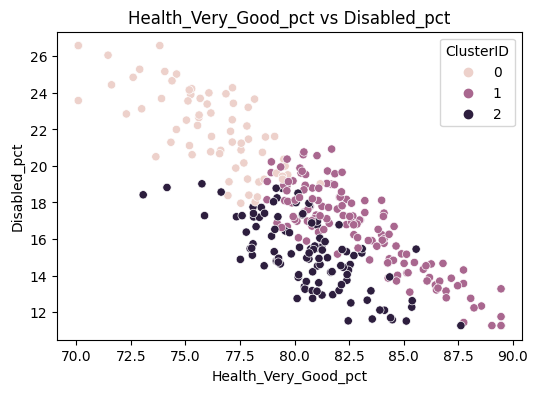

In [89]:
fig = plt.figure(figsize = (6,4))
sns.scatterplot(x='Health_Very_Good_pct',y='Disabled_pct',hue='ClusterID',legend='full',data=dat6)
plt.xlabel('Health_Very_Good_pct', fontsize=10)
plt.ylabel('Disabled_pct', fontsize=10)
plt.title('Health_Very_Good_pct vs Disabled_pct')
plt.show()

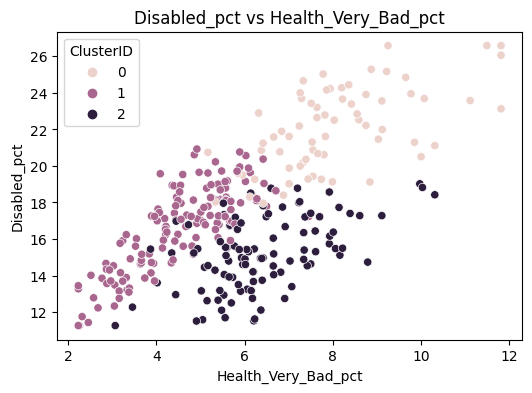

In [90]:
fig = plt.figure(figsize = (6,4))
sns.scatterplot(x='Health_Very_Bad_pct',y='Disabled_pct',hue='ClusterID',legend='full',data=dat6)
plt.xlabel('Health_Very_Bad_pct', fontsize=10)
plt.ylabel('Disabled_pct', fontsize=10)
plt.title('Disabled_pct vs Health_Very_Bad_pct')
plt.show()

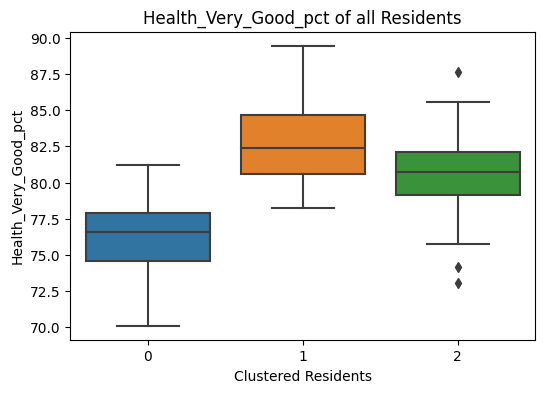

In [91]:
fig = plt.figure(figsize = (6,4))
sns.boxplot(x='ClusterID',y='Health_Very_Good_pct',data=dat6)
plt.xlabel('Clustered Residents', fontsize=10)
plt.ylabel('Health_Very_Good_pct', fontsize=10)
plt.title('Health_Very_Good_pct of all Residents')
plt.show()

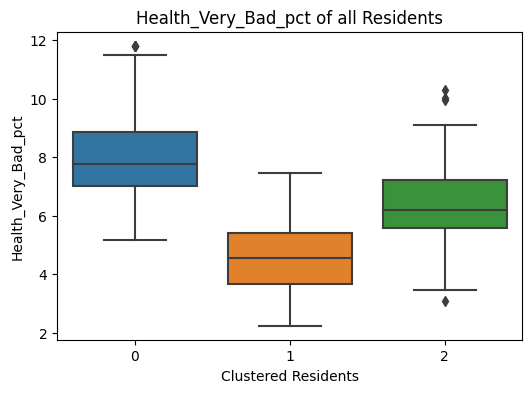

In [92]:
fig = plt.figure(figsize = (6,4))
sns.boxplot(x='ClusterID',y='Health_Very_Bad_pct',data=dat6)
plt.xlabel('Clustered Residents', fontsize=10)
plt.ylabel('Health_Very_Bad_pct', fontsize=10)
plt.title('Health_Very_Bad_pct of all Residents')
plt.show()

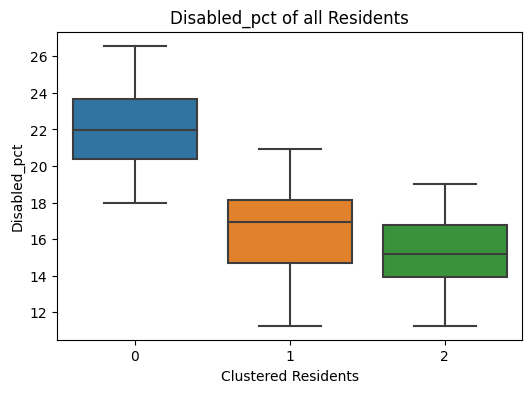

In [93]:
fig = plt.figure(figsize = (6,4))
sns.boxplot(x='ClusterID',y='Disabled_pct',data=dat6)
plt.xlabel('Clustered Residents', fontsize=10)
plt.ylabel('Disabled_pct', fontsize=10)
plt.title('Disabled_pct of all Residents')
plt.show()

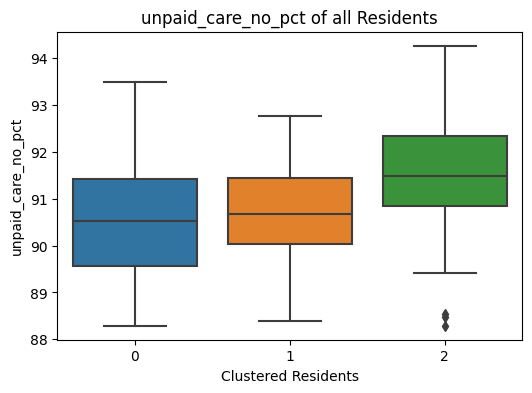

In [94]:
fig = plt.figure(figsize = (6,4))
sns.boxplot(x='ClusterID',y='unpaid_care_no_pct',data=dat6)
plt.xlabel('Clustered Residents', fontsize=10)
plt.ylabel('unpaid_care_no_pct', fontsize=10)
plt.title('unpaid_care_no_pct of all Residents')
plt.show()

<div class="alert alert-block alert-info">
<b>Insight:</b> 
From the above bar plots, the clusters formed has the following meaning,

Brown samples (cluster 0): Unhealthy residents with high ranking for very bad health population with high disability and high unpaid care provision.  

    
Pink samples (cluster 1): Healthy residents with a high proportion of very good health and less population do disabled population.

Purple samples (cluster 2): Fair health residents with average people who are in good health and disability with good unpaid care provision given when compared to other clusters.

</div>

## 6. Performing Hierarchical Clustering

In [95]:
pcs_df2.shape

(312, 5)

In [96]:
pcs_df3 = pd.DataFrame({'PC1':pc[0],'PC2':pc[1],'PC3':pc[2],'PC4':pc[3],'PC5':pc[4]})

In [97]:
dat_km.head()

,PC1,PC2,PC3,PC4,PC5,ClusterID
0,0.024420,3.044545,0.548275,-0.163418,-0.851572,1
1,-5.023779,0.588493,-0.215469,0.039661,0.910724,0
2,-0.140401,3.345080,-0.147517,-0.011391,-0.659668,1
3,-0.809281,1.472416,1.751808,0.170978,-0.494251,1
4,0.634435,3.447666,0.866698,-0.322063,-0.507710,1


### 6.1 Performing Single Linkage

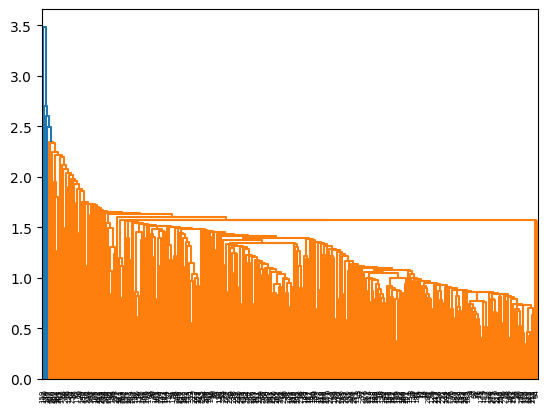

In [98]:
mergings=linkage(pcs_df2,method='single',metric='euclidean')
dendrogram(mergings)
plt.show()

### 6.2 Performing Complete Linkage

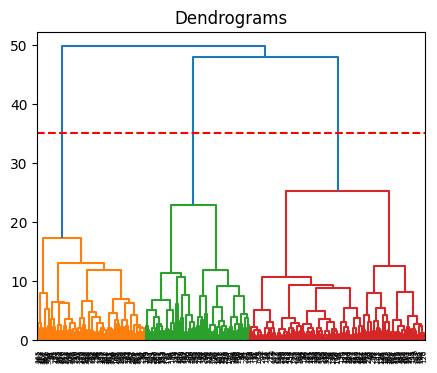

In [99]:
plt.figure(figsize=(5, 4))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(pcs_df2, method='ward'))
plt.axhline(y=35, color='r', linestyle='--')

In [100]:
# From above dendrograms, we can derive the 3 clusters.

cut_tree(mergings,n_clusters=3).shape

(312, 1)

In [101]:
# Let's reshape the cut_tree result array

cluser_labels=cut_tree(mergings,n_clusters=3).reshape(-1,)
cluser_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [102]:
# #assign cluster labels

dat_km['Cluster_lables']=cluser_labels
dat_km.head()

,PC1,PC2,PC3,PC4,PC5,ClusterID,Cluster_lables
0,0.024420,3.044545,0.548275,-0.163418,-0.851572,1,0
1,-5.023779,0.588493,-0.215469,0.039661,0.910724,0,0
2,-0.140401,3.345080,-0.147517,-0.011391,-0.659668,1,0
3,-0.809281,1.472416,1.751808,0.170978,-0.494251,1,0
4,0.634435,3.447666,0.866698,-0.322063,-0.507710,1,0


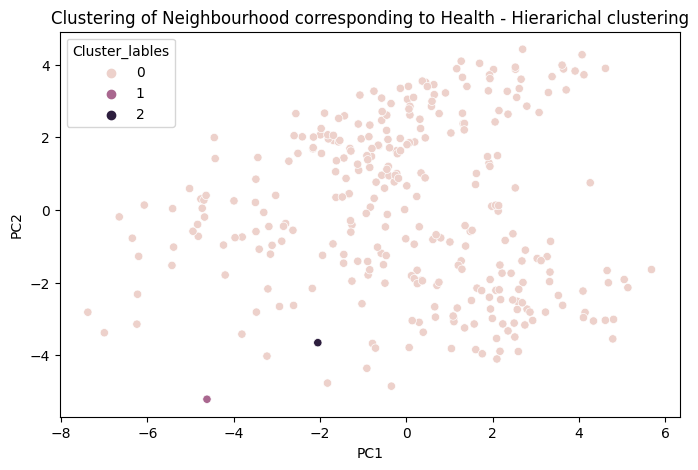

In [103]:
fig = plt.figure(figsize = (8,5))
sns.scatterplot(x='PC1',y='PC2',hue='Cluster_lables',legend='full',data=dat_km)

plt.title('Clustering of Neighbourhood corresponding to Health - Hierarichal clustering')
plt.show()

In [104]:
dat7=pd.merge(data,dat_km, left_index=True,right_index=True)
dat7.head()

,index,LSOA,Asian_pct,Black_pct,White_pct,Others_pct,Health_Very_Good_pct,Health_Fair_pct,Health_Very_Bad_pct,Disabled_pct,...,unpaid_care_up9to49_pct,unpaid_care_no_pct,unpaid_care_above50_pct,PC1,PC2,PC3,PC4,PC5,ClusterID,Cluster_lables
0,0,E01010568,2.44,0.64,95.12,1.80,83.01,11.98,5.00,17.04,...,13.74,90.82,1.91,0.024420,3.044545,0.548275,-0.163418,-0.851572,1,0
1,1,E01010569,1.20,0.97,95.44,2.39,77.16,14.64,8.20,24.27,...,11.37,89.72,4.21,-5.023779,0.588493,-0.215469,0.039661,0.910724,0,0
2,2,E01010570,4.14,0.27,94.12,1.47,84.10,11.49,4.41,17.42,...,14.50,90.24,2.30,-0.140401,3.345080,-0.147517,-0.011391,-0.659668,1,0
3,3,E01010571,2.68,1.39,90.99,4.94,81.69,12.91,5.40,19.00,...,11.27,91.88,2.04,-0.809281,1.472416,1.751808,0.170978,-0.494251,1,0
4,4,E01010572,1.82,0.27,95.95,1.96,83.55,13.22,3.24,15.91,...,13.19,91.33,1.83,0.634435,3.447666,0.866698,-0.322063,-0.507710,1,0


In [105]:
dat8=dat7.drop(['PC1','PC2','PC3','PC4','PC5'],axis=1)
dat8.shape

(312, 20)

In [106]:
dat8.head()

,index,LSOA,Asian_pct,Black_pct,White_pct,Others_pct,Health_Very_Good_pct,Health_Fair_pct,Health_Very_Bad_pct,Disabled_pct,Disability_limited_lot_pct,Disability_limited_little_pct,Disability_No_pct,Disability_phy_mental_yes_pct,Disability_phy_mental_no_pct,unpaid_care_up9to49_pct,unpaid_care_no_pct,unpaid_care_above50_pct,ClusterID,Cluster_lables
0,0,E01010568,2.44,0.64,95.12,1.80,83.01,11.98,5.00,17.04,6.05,10.99,82.96,8.61,74.35,13.74,90.82,1.91,1,0
1,1,E01010569,1.20,0.97,95.44,2.39,77.16,14.64,8.20,24.27,11.11,13.16,75.73,6.89,68.83,11.37,89.72,4.21,0,0
2,2,E01010570,4.14,0.27,94.12,1.47,84.10,11.49,4.41,17.42,7.08,10.35,82.58,9.01,73.56,14.50,90.24,2.30,1,0
3,3,E01010571,2.68,1.39,90.99,4.94,81.69,12.91,5.40,19.00,7.65,11.35,81.00,7.81,73.19,11.27,91.88,2.04,1,0
4,4,E01010572,1.82,0.27,95.95,1.96,83.55,13.22,3.24,15.91,4.65,11.26,84.09,8.97,75.12,13.19,91.33,1.83,1,0


In [107]:
dat8.to_csv('Dataset/Processed_data/Clustered_data.csv')

## 7. Analysis of the clusters

In [108]:
Cluster_Health_Very_Good_pct_H=pd.DataFrame(dat8.groupby(["Cluster_lables"]).Health_Very_Good_pct.mean())
Cluster_Disability_No_pct_H=pd.DataFrame(dat8.groupby(["Cluster_lables"]).Disability_No_pct.mean())
Cluster_unpaid_care_above50_pct_H=pd.DataFrame(dat8.groupby(["Cluster_lables"]).unpaid_care_above50_pct.mean())

In [109]:
df_H = pd.concat([Cluster_Health_Very_Good_pct_H,Cluster_Disability_No_pct_H,Cluster_unpaid_care_above50_pct_H], axis=1)

In [110]:
df_H.columns = ["Health_Very_Good_pct","Disability_No_pct","unpaid_care_no_pct"]
df_H

,Health_Very_Good_pct,Disability_No_pct,unpaid_care_no_pct
Cluster_lables,,,
0,80.675994,82.707245,2.798634
1,70.098300,76.430000,3.270000
2,73.650000,79.500000,2.610000


In [111]:
# Filtering the final list of less health neighbourhood where, more focus is required.

In [112]:
#Let's use the concept of binning
fin_H=data[data['Health_Very_Good_pct'] >= 80.008347]
fin_H=fin[fin['Disability_No_pct'] <= 83.879579]
fin_H=fin[fin['unpaid_care_no_pct'] >= 3.527644]

In [113]:
fin_H=pd.merge(fin_H,dat_km,left_index=True,right_index=True)

In [114]:
fin_H=fin_H.drop(['PC1','PC2','PC3','PC4','PC5'],axis=1)
fin_H.shape

(16, 20)

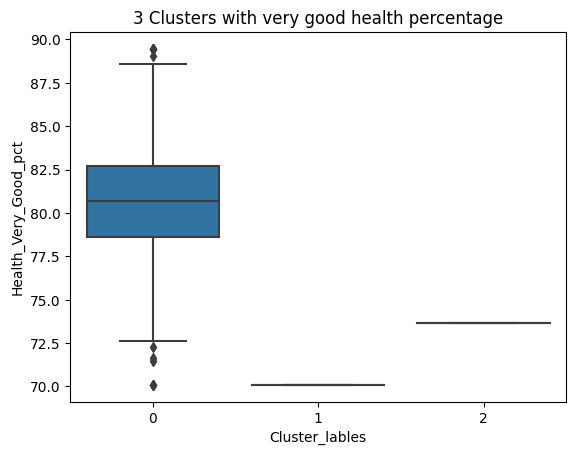

In [115]:
sns.boxplot(x='Cluster_lables',y='Health_Very_Good_pct',data=dat8)
plt.title('3 Clusters with very good health percentage')
plt.show()

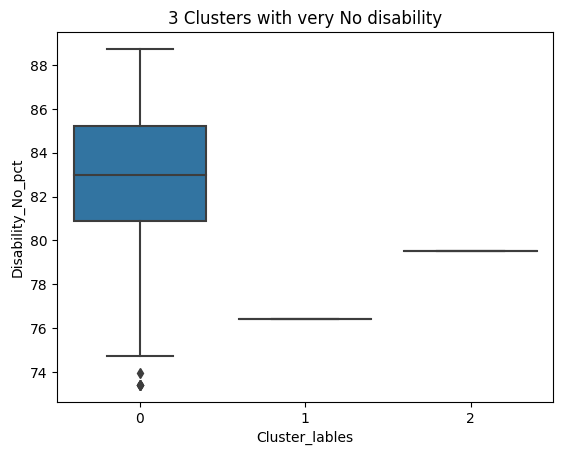

In [116]:
sns.boxplot(x='Cluster_lables',y='Disability_No_pct',data=dat8)
plt.title('3 Clusters with very No disability')
plt.show()

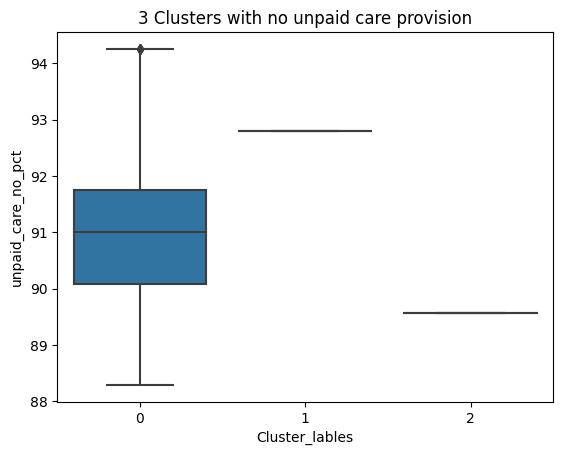

In [117]:
sns.boxplot(x='Cluster_lables',y='unpaid_care_no_pct',data=dat8)
plt.title('3 Clusters with no unpaid care provision')
plt.show()

In [118]:
fin_H.nsmallest(8,'Health_Very_Good_pct')

,index,LSOA,Asian_pct,Black_pct,White_pct,Others_pct,Health_Very_Good_pct,Health_Fair_pct,Health_Very_Bad_pct,Disabled_pct,Disability_limited_lot_pct,Disability_limited_little_pct,Disability_No_pct,Disability_phy_mental_yes_pct,Disability_phy_mental_no_pct,unpaid_care_up9to49_pct,unpaid_care_no_pct,unpaid_care_above50_pct,ClusterID,Cluster_lables
245,245,E01010818,27.0300,1.79,64.82,6.3700,83.44,12.18,4.38,14.86,7.02,7.84,85.14,5.6200,79.52,14.90,89.67,2.39,1,0
136,136,E01010707,17.3200,0.27,76.60,5.8100,84.27,12.07,3.66,14.69,5.46,9.23,85.31,7.5900,77.72,13.89,89.66,2.80,1,0
78,78,E01010646,0.8200,0.30,97.92,0.9700,84.72,12.76,2.52,14.02,4.75,9.27,85.98,10.0324,75.22,14.04,90.10,2.23,1,0
286,286,E01010862,0.4366,0.18,97.74,1.8300,85.13,11.20,3.67,15.17,5.26,9.91,84.83,8.2000,76.64,12.76,90.13,3.21,1,0
5,5,E01010573,2.0200,0.33,96.77,0.8744,85.15,10.97,3.88,14.15,5.85,8.31,85.85,8.0300,77.81,14.40,89.44,2.87,1,0
287,287,E01010863,1.4900,0.35,96.61,1.5600,85.49,10.62,3.89,14.72,5.10,9.62,85.28,8.8500,76.43,15.27,89.40,2.59,1,0
199,199,E01010771,1.5500,0.33,95.93,2.2000,86.02,10.96,3.03,14.54,4.82,9.72,85.46,10.0324,75.41,12.41,90.50,3.00,1,0
224,224,E01010797,8.1400,1.20,88.17,2.4800,86.07,10.96,2.97,13.71,5.30,8.41,86.29,7.8400,78.45,14.81,90.28,1.80,1,0


## 8. Validation of clusters: 

### 8.1 Dunn index :

In [119]:
# Three distinct clusters are derived from k-means clusters
clus0 = validation_df.loc[validation_df.ClusterID == 0]
clus1 = validation_df.loc[validation_df.ClusterID == 1]
clus2 = validation_df.loc[validation_df.ClusterID == 2]
k_list = [clus0.values, clus1.values,clus2.values]

In [120]:
def data_dunn_index (data):
    
    # three distinct clusters
    clus2 = data.loc[data.ClusterID == 0]
    clus1 = data.loc[data.ClusterID == 1]
    clus2 = data.loc[data.ClusterID == 2]
    k_list = [clus0.values, clus1.values,clus2.values]
    
    # focus now on two of these cluster
    ck = k_list[0]
    cl = k_list[2]
    
    # We know we have to calculate the distance between the points in  and . We know that the len(ck)=len(cl)=333 we create
    values = np.ones([len(ck), len(cl)])
    #values
    
    # For each pair of points, we then get the norm of . For instance, for  and , we would have:
    values[0, 1] = np.linalg.norm(ck[0]-cl[1])
    #print(ck[0], cl[1])
    #print(values[0, 1])
    return (ck[0], cl[1])
    return (values)

In [121]:
# focus now on two of these cluster

ck = k_list[0]
cl = k_list[2]

In [122]:
# We know we have to calculate the distance between the points in  and . We know that the len(ck)=len(cl)=333 we create

values = np.ones([len(ck), len(cl)])
values

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [123]:
# For each pair of points, we then get the norm of . For instance, for  and , we would have:

values[0, 1] = np.linalg.norm(ck[0]-cl[1])
print(ck[0], cl[1])
print(values[0, 1])

[-5.02377892  0.58849325 -0.21546883  0.03966142  0.91072367  0.        ] [ 0.70721433 -2.07661836  0.40077769 -0.03801126 -0.39000652  2.        ]
6.784157681523451


In [124]:
# The calculation of  between two clusters  and  will be defined as follows:

def δ(ck, cl):  
    values = np.ones([len(ck), len(cl)])
    for i in range(0, len(ck)):
        for j in range(0, len(cl)):
            values[i, j] = np.linalg.norm(ck[i]-cl[j])
    return np.min(values)

In [125]:
# So, for our two clusters above,  will be:

δ(ck, cl)

2.0856965339319724

In [126]:
# Within a single cluster , we can calculate  similarly as:

def Δ(ci):
    values = np.zeros([len(ci), len(ci)])
    for i in range(0, len(ci)):
        for j in range(0, len(ci)):
            values[i, j] = np.linalg.norm(ci[i]-ci[j])
    return np.max(values)

In [127]:
# We can now define the Dunn index as

print(Δ(ck))
print(Δ(cl))

8.764406362194784
10.384283478240969


In [128]:
# calculate the Dunn index for our clustered values list as

def dunn(k_list):
    δs = np.ones([len(k_list), len(k_list)])
    Δs = np.zeros([len(k_list), 1])
    l_range = list(range(0, len(k_list)))
    for k in l_range:
        for l in (l_range[0:k]+l_range[k+1:]):
            δs[k, l] = δ(k_list[k], k_list[l])
            Δs[k] = Δ(k_list[k])
            di = np.min(δs)/np.max(Δs)
    return di

In [129]:
dunn(k_list)

0.09629937415473885

<div class="alert alert-block alert-info">
<b>Insight:</b> 
Dunn index for the clustered values list was .0962 which is decently a good score. This indicates a compact, well-separated clusters.
</div>

### 8.2 Calinski-Harabasz index

In [130]:
X_km = validation_df.iloc[:,:-1]
y_km = validation_df.loc[:,['ClusterID']]

In [131]:
X_hc = dat_km.iloc[:,:-2]
y_hc = dat_km.loc[:,['Cluster_lables']]

In [132]:
from sklearn.metrics import calinski_harabasz_score

# Calculate the Calinski-Harabasz index
km_score = calinski_harabasz_score(X_km, y_km)
hc_score = calinski_harabasz_score(X_hc, y_hc)

print("Calinski-Harabasz index for k-means clustering:", km_score)
print("Calinski-Harabasz index for Hierarichal clustering:", hc_score)

Calinski-Harabasz index for k-means clustering: 176.4088396127671
Calinski-Harabasz index for Hierarichal clustering: 3.051701184029408


<div class="alert alert-block alert-info">
<b>Insight:</b> 
By calculating the between-cluster variance by the within-cluster variance, 
the Calinski-Harabasz index yielded a score of 176.4 for k-means which is pretty good for the dataset in hand
This indicates k-means has good separation of the clusters and a better clustering result compared to hierarichal clustering.

</div>